In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F, Window as W

from grocery.utils.io import read_spark_data
from grocery.utils.config import get_config

import matplotlib.pyplot as plt

In [5]:
spark = (SparkSession.builder
         .config("spark.master", "local[1]")
         .appName("grocery")
         .getOrCreate())
spark.sparkContext.setLogLevel("FATAL")

In [6]:
# Read raw trx data
df = read_spark_data(spark,**get_config()['data']['raw']['trx'])

In [7]:
# Save as parquet file
(df
 .write
 .mode('overwrite')
 .option("overwriteSchema", "true")
 .option("compression", "gzip")
 .parquet(get_config()['data']['standardized']['trx']['filepath']))

In [8]:
# Read standardized parquet file
df = read_spark_data(spark, **get_config()['data']['standardized']['trx'])

In [9]:
# Find top selling UPC
upc = df.groupby('upc').agg(F.sum('spend').alias('spend')).orderBy(F.desc('spend')).drop('spend').limit(1)

# Group to weekly level
trx = df.join(upc,['upc'])
trx.persist()
trx.show(5, False)

# Get average metrics
aggs = [
    F.sum('units').alias('units'),
    (F.sum('spend')/F.sum('units')).alias('avg_price'),
    F.avg('feature').alias('pct_feature'),
    F.avg('display').alias('pct_display'),
]
trx = trx.groupby('week_end_date').agg(*aggs)

+----------+-------------+---------+-----+------+----+------+-----+----------+-------+-------+--------+
|upc       |week_end_date|store_num|units|visits|hhs |spend |price|base_price|feature|display|tpr_only|
+----------+-------------+---------+-----+------+----+------+-----+----------+-------+-------+--------+
|1600027527|2009-01-14   |367      |12.0 |10.0  |10.0|38.28 |3.19 |3.19      |0.0    |0.0    |0.0     |
|1600027527|2009-01-14   |387      |74.0 |65.0  |65.0|226.44|3.06 |3.06      |0.0    |0.0    |0.0     |
|1600027527|2009-01-14   |389      |52.0 |51.0  |51.0|156.52|3.01 |3.01      |0.0    |0.0    |0.0     |
|1600027527|2009-01-14   |613      |47.0 |44.0  |44.0|149.93|3.19 |3.19      |0.0    |0.0    |0.0     |
|1600027527|2009-01-14   |623      |57.0 |55.0  |54.0|181.83|3.19 |3.19      |0.0    |0.0    |0.0     |
+----------+-------------+---------+-----+------+----+------+-----+----------+-------+-------+--------+
only showing top 5 rows



In [10]:
# Calculate base-price as the max for running 26 weeks
w = W.orderBy('week_end_date').rowsBetween(-26,0)
trx = trx.withColumn('base_price',F.max('avg_price').over(w))
d = trx.orderBy('week_end_date').toPandas()

22-11-17 20:14:46: [INFO]: 145: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
22-11-17 20:14:46: [INFO]: 157: NumExpr defaulting to 8 threads.


22-11-17 20:14:49: [WARNING]: 1350: findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.


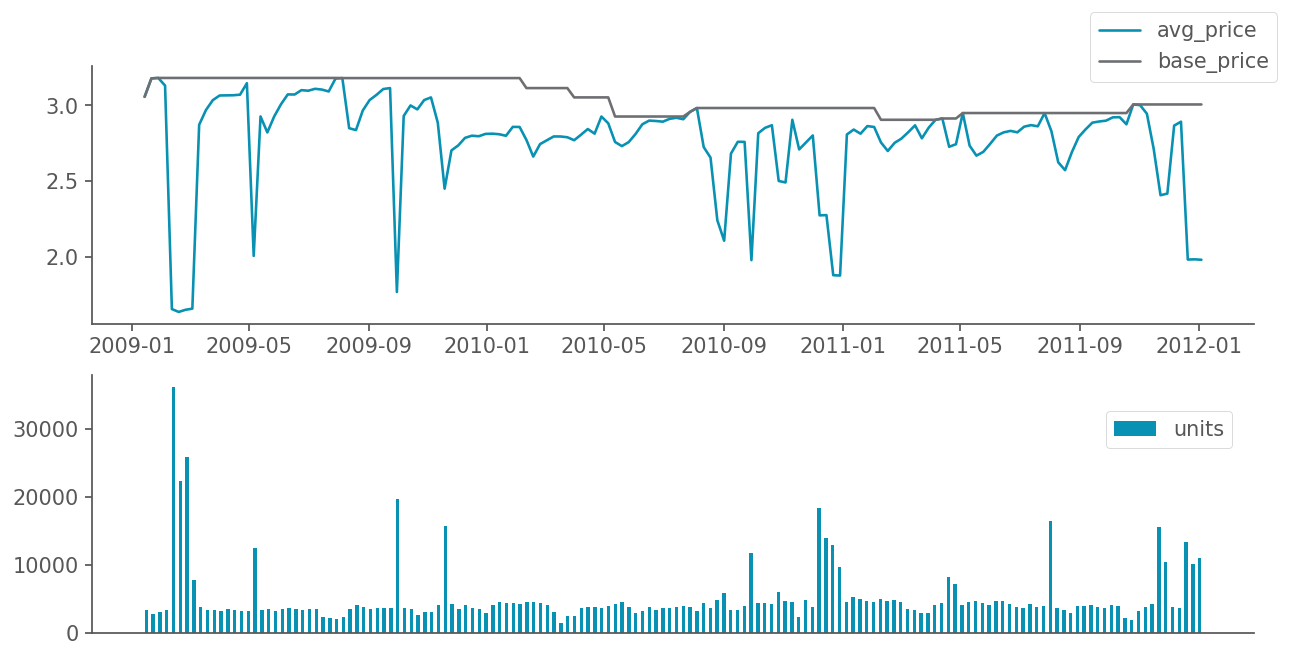

In [11]:
plt.style.use("custom.mplstyle")

# Plot example item
fig,ax = plt.subplots(figsize=(12,6),nrows=2)
ax[0].plot(d['week_end_date'], d['avg_price'], label='avg_price')
ax[0].plot(d['week_end_date'], d['base_price'], label='base_price')
ax[1].bar(d['week_end_date'], d['units'],width=3.5, label='units')

# Update axis & legend
ax[1].get_xaxis().set_visible(False)
ax[0].legend(bbox_to_anchor=(0.85, 0.9))
ax[1].legend(bbox_to_anchor=(0.99, 0.9))